# CS 510 Project 3-0

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Part 0: train your own MNIST model

The following training code is mainly based on [TensorFlow 2 quickstart for experts](https://www.tensorflow.org/tutorials/quickstart/advanced). The goal of this part is to familiarize yourself with basic usage of Colab notebook and TensorFlow. In this part, you only need to learn and run the code. By the end of this part, you will get a neural network which can classifiy the handwritten data with ~98% accuracy.

This is a [Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb) notebook file. Python programs are run directly in the browser—a great way to learn and use TensorFlow. To follow this tutorial, run the notebook in Google Colab by clicking the button at the top of this page.

1. In Colab, connect to a Python runtime: At the top-right of the menu bar, select *CONNECT*.
2. Run all the notebook code cells: Select *Runtime* > *Run all*.


Download and install TensorFlow 2. Import TensorFlow into your program:

Note: Upgrade `pip` to install the TensorFlow 2 package. See the [install guide](https://www.tensorflow.org/install) for details.

Import TensorFlow into your program:

In [2]:
import random
import numpy as np

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
tf.keras.utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()

TensorFlow version: 2.8.0


Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

Use `tf.data` to batch and shuffle the dataset:

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

Show some training images.

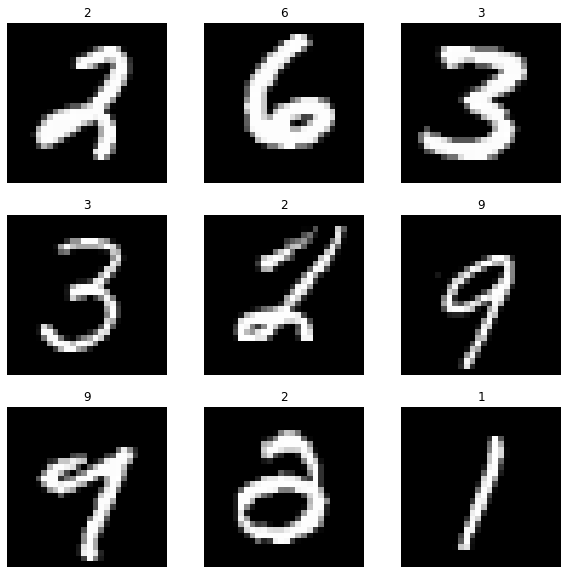

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i]*255).numpy().astype("uint8").reshape(28, 28), cmap='gray', vmin=0, vmax=255)
    plt.title(labels[i].numpy())
    plt.axis("off")

Build the `tf.keras` model using the Keras [model subclassing API](https://www.tensorflow.org/guide/keras#model_subclassing):

In [6]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.flatten = Flatten()
    self.d0 = Dense(300, activation='relu')
    self.d1 = Dense(200, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    x = self.flatten(x)
    x = self.d0(x)
    x = self.d1(x)
    return self.d2(x)

  def get_internal_activations(self, x):
    x = self.flatten(x)
    x_d0 = self.d0(x)
    x_d1 = self.d1(x_d0)
    x_d2 = self.d2(x_d1)
    return x_d0, x_d1, x_d2

# Create an instance of the model
model = MyModel()

Choose an optimizer and loss function for training: 

In [7]:
#@tf.function
def loss_object(target, pred):
  target = tf.one_hot(target, 10)
  pred_conf = tf.nn.softmax(pred)
  cross_entropy = -tf.reduce_sum(target * tf.math.log(pred_conf))
  return cross_entropy

optimizer = tf.keras.optimizers.Adam()

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [8]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

Use `tf.GradientTape` to train the model:

In [9]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

Test the model:

In [10]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 6.265469074249268, Accuracy: 94.13333892822266, Test Loss: 3.3146731853485107, Test Accuracy: 96.73999786376953
Epoch 2, Loss: 2.6318907737731934, Accuracy: 97.40666961669922, Test Loss: 3.4248721599578857, Test Accuracy: 96.79000091552734
Epoch 3, Loss: 1.7911698818206787, Accuracy: 98.22666931152344, Test Loss: 2.5635366439819336, Test Accuracy: 97.61000061035156


The image classifier is now trained to ~98% accuracy on this dataset. To learn more, read the [TensorFlow tutorials](https://www.tensorflow.org/tutorials).

# Part 1: find inputs exposing the bugs

In this part, you need to find a set of 9 inputs which can:

1. cover at least 85% neurons (with threshold 0.4). A neuron is covered if its activation value (after the activation function) is larger than the threshold.
2. trigger the bugs in the loss function `loss_object` so that the loss is inf / nan.

You don't need to change any code in Part 0.

We will evaluate the neuron coverage using the following `eval_nac` function.

In [ ]:
expected_nac = 0.85
nac_threshold = 0.4
@tf.function
def eval_nac(x):
  x_d0, x_d1, _ = model.get_internal_activations(x)
  cnt_d0 = tf.reduce_sum(tf.cast(tf.reduce_any(x_d0>nac_threshold, axis=0), tf.float32))
  cnt_d1 = tf.reduce_sum(tf.cast(tf.reduce_any(x_d1>nac_threshold, axis=0), tf.float32))
  nac = (cnt_d0+cnt_d1)/tf.cast(x_d0.shape[1]+x_d1.shape[1], tf.float32)
  return nac

Let's test how much coverage a random input can achieve.

In [ ]:
x = tf.random.uniform([1, 28, 28, 1])
eval_nac(x)

Please develop your loss function and algorithm to find the desired inputs. The high-level idea is similar to training a model or generating adversarial examples.

**Note: Please do not change code before this cell and start your code in the next cell.**


```
def my_loss_object(...):
  ...
def explore(...):
  inputs = ...
  outputs = model.get_internal_activations(x)
  loss = my_loss_object(outputs, ...)
  # compute the gradient using `tf.GradientTape`
  # update inputs according to the gradient
  # succeed if `loss_object` output is nan/inf and `eval_nac > expected_nac`
```



# Sandhya's Solution


In [ ]:
@tf.function
#calculating total loss
def my_loss_object(x_d0, x_d1,pred):
    return bug_loss_object(pred) + nac_loss_object(x_d0, x_d1)
#calculating NAC loss
def nac_loss_object(x_d0, x_d1):
    x_d1 = -1*(tf.math.minimum(x_d1,nac_threshold))
    x_d0 = -1*(tf.math.minimum(x_d0,nac_threshold))
    return tf.reduce_sum(x_d0)+ tf.reduce_sum(x_d1)
#calculating loss bug
def bug_loss_object(pred):
    pred_conf = tf.nn.softmax(pred)
    lossbug = tf.math.reduce_min(pred_conf)
    return lossbug

In [ ]:
def explore():
  EPOCHS = 1000
  #initialise inputs
  inputs = tf.Variable(x_test[:9])
  # set the lr.
  step= 0.05
  for epoch in range(EPOCHS):
  # inputs need to be tf.Variable to get gradients
    inputs = tf.Variable(inputs)
    pred = model(inputs, training=False)

    with tf.GradientTape() as tape:
      x_d0, x_d1, _ = model.get_internal_activations(inputs)
      calcloss = my_loss_object(x_d0,x_d1,pred)
   
  # compute the gradient
    gradients = tape.gradient(calcloss, inputs)
  #optimizer.apply_gradients(zip([gradients], [inputs]))
  #use grad to update inputs.
    inputs = inputs - tf.math.sign(gradients) * step
  # clip the inputs into the legitimate range
    inputs = tf.clip_by_value(inputs, 0., 1.)
    calculated_nac= eval_nac(inputs)
    new_predc = model(inputs, training=False)
    lossbug=loss_object(9, new_predc)
    print(epoch, calculated_nac, lossbug) 
  #exit the loop if the expected nac is achieved and the bug is triggered  
    if((tf.math.is_nan(lossbug) or tf.math.is_inf(lossbug)) and calculated_nac>expected_nac ):
      #print(epoch, "NAC:", calculated_nac,"loss", lossbug) 
      return inputs
      break
explore()